In [1]:
!pip install -U datasets
!pip install evaluate
!pip install loralib
!pip install mplcyberpunk
!pip install peft
!pip install rouge_score
!pip install torch
!pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 7.4 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: datasets
    Found existing installation: datasets 2.1.0
    Uninstalling datasets-2.1.0:
      Successfully uninstalled datasets-2.1.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 kB 3.4 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=5666748b34133fa9364c7853288cbe8cbebeb520914a81fe73a9f4efb3ecc740
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [2]:
import os
import random
import re
import time

import evaluate
import gc
import matplotlib.pyplot as plt
import mplcyberpunk
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.cuda as cuda
from datasets import Dataset, load_dataset
from evaluate import load
from peft import LoraConfig, TaskType, get_peft_model, PeftModel
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader
from transformers import (AutoConfig, AutoTokenizer, Trainer, TrainerCallback,
                          TrainerControl, TrainerState, TrainingArguments)

nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

en_stopwords = stopwords.words('english')

import warnings

warnings.filterwarnings("ignore")

2024-03-13 18:41:13.330413: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-13 18:41:13.330561: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-13 18:41:13.495694: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


seed_everything(42)

In [4]:
plt.style.use("cyberpunk")

## **Dataset preprocessing**

In [5]:
dataset = load_dataset("hakurei/open-instruct-v1", split='train').to_pandas()

Generating train split: 0 examples [00:00, ? examples/s]

In [6]:
dataset.head()

,output,input,instruction
0,1. Eat a balanced diet and make sure to includ...,,Give three tips for staying healthy.
1,"The three primary colors are red, blue, and ye...",,What are the three primary colors?
2,"An atom is made up of a nucleus, which contain...",,Describe the structure of an atom.
3,There are a number of ways to reduce air pollu...,,How can we reduce air pollution?
4,I had to make a difficult decision when I was ...,,Pretend you are a project manager of a constru...


In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498813 entries, 0 to 498812
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   output       498813 non-null  object
 1   input        498813 non-null  object
 2   instruction  498813 non-null  object
dtypes: object(3)
memory usage: 11.4+ MB


In [8]:
dataset.drop(['input'], axis=1, inplace=True)

In [9]:
dataset.isnull().sum()

output         0
instruction    0
dtype: int64

In [10]:
dataset.drop_duplicates(inplace=True)
dataset.reset_index(inplace=True, drop=True)

In [11]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266973 entries, 0 to 266972
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   output       266973 non-null  object
 1   instruction  266973 non-null  object
dtypes: object(2)
memory usage: 4.1+ MB


In [12]:
# Некоторые незаполненные строки в колонке instruction имели текст '<noinput>', поэтому удалим их
dataset = dataset.drop(dataset[dataset['instruction'] == '<noinput>'].index)
dataset.reset_index(inplace=True, drop=True)

In [13]:
# Удалим строки, не содержащие текст на английском языке или цифры. Например, арабскую вязь: أبي صاحب أبي هو عمي
for i in range(len(dataset.instruction)): 
    if not re.findall(r'[A-Za-z\d]+', dataset.instruction[i]) or not re.findall(r'[A-Za-z\d]+', dataset.output[i]): 
        dataset.drop([i], axis=0, inplace=True)
dataset.reset_index(inplace=True, drop=True)

In [14]:
# Удалим код и SQL запросы, так как для того, чтобы научить модель отвечать на вопросы, связанные с кодом, нужно тюнить ее под датасет именно с такими данными 
# В данном же случае, когда мы хотим научить модель отвечать на вопросы на английском языке, 
# лучше почистить данные и оставить только обычные вопросы на естественном языке

def is_code(text):
    patterns = [
        r'\bdef\b', 
        r'\bif\b', 
        r'\bfor\b',  
        r'\bwhile\b',
        r'\breturn\b', 
        r'=>', 
        r'\(',  
        r'={1}',
        r'==', 
        r'\bSELECT\b', 
        r'\bFROM\b',
    ]
    
    if any(re.search(pattern, text) for pattern in patterns):
        return True
    else:
        return False


dataset = dataset[~dataset['instruction'].apply(is_code)]
dataset.reset_index(inplace=True, drop=True)

dataset = dataset[~dataset['output'].apply(is_code)]
dataset.reset_index(inplace=True, drop=True)

### Посмотрим подробнее на длину наших текстов

In [15]:
def get_lengths(df, column):
    lengths = []
    for i in range(len(df[f'{column}'])):
        lengths.append(len(df[f'{column}'][i].split(' ')))
    return lengths

In [16]:
def get_texts_with_certain_length(df, column, length):
    texts = []
    for i in range(len(df[f'{column}'])):
        if (len(df[f'{column}'][i].split(' '))) <= length: 
            texts.append(df[f'{column}'][i])
    return texts

In [17]:
lengths_output = get_lengths(dataset, 'output')
lengths_instructions = get_lengths(dataset, 'instruction')

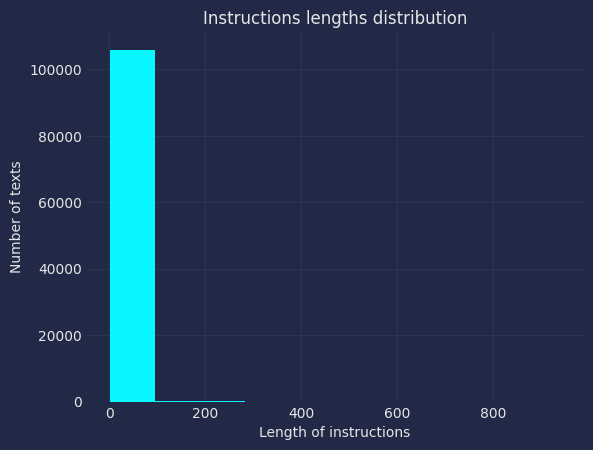

In [21]:
plt.axes_ticklabels_overlaphist(lengths_instructions)
plt.xlabel('Length of instructions')
plt.ylabel('Number of texts')
plt.title('Instructions lengths distribution')
plt.show()

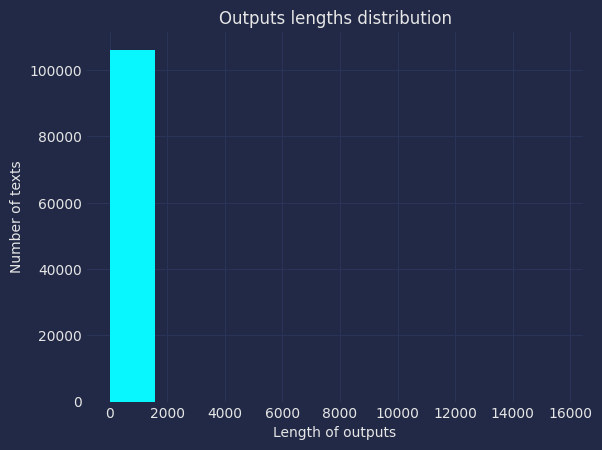

In [20]:
plt.hist(lengths_output)
plt.xlabel('Length of outputs')
plt.ylabel('Number of texts')
plt.title('Outputs lengths distribution')
plt.show()

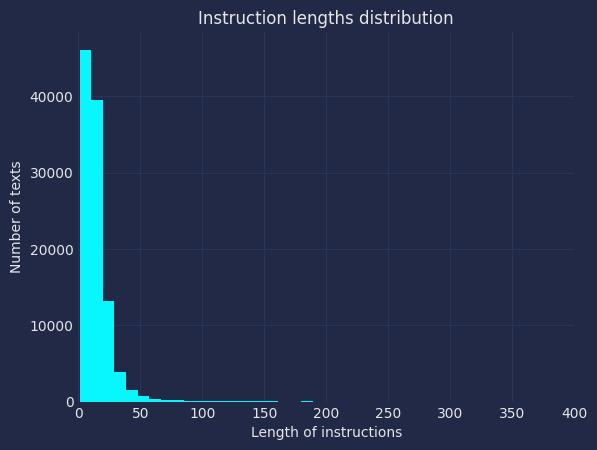

In [39]:
# Исходя из графиков выше, текстов длиной свыше 400 нет, поэтому посмотрим на этот отрезок в приближении
plt.hist(lengths_instructions, bins=100)
plt.xlabel('Length of instructions')
plt.ylabel('Number of texts')
plt.title('Instruction lengths distribution')
plt.xlim(0, 400)
plt.show()

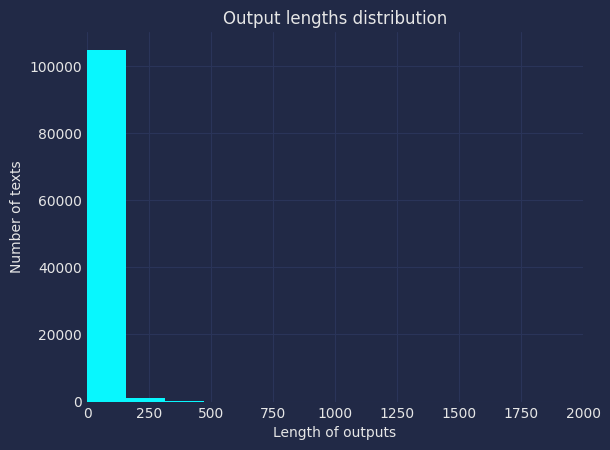

In [37]:
# Исходя из графиков выше, текстов длиной свыше 2000 нет, поэтому посмотрим на этот отрезок в приближении
plt.hist(lengths_output, bins=100)
plt.xlabel('Length of outputs')
plt.ylabel('Number of texts')
plt.title('Output lengths distribution')
plt.xlim(0, 2000)
plt.show()

In [30]:
# Можно увидеть, что вопросы длиной меньше 2 токенов в большинстве своем представляют собой мусор
small_instructions = get_texts_with_certain_length(dataset, 'instruction', 2)
small_instructions[:10]

['Calculate 3/.',
 'Is.',
 'reincarnation exists?',
 'https://en.wikipedia.org/wiki/Wissam_Ben_Yedder#Club',
 'Tesrt',
 'Test',
 'Explain pickball',
 'Turtle ship',
 'Hello',
 'Hello hello']

In [31]:
# Ответы же могут быть даже длиной всего 1 токен, поэтому их мы убирать не будем 
small_outputs = get_texts_with_certain_length(dataset, 'output', 1)
small_outputs[:10]

['Telegram',
 'Transitive.',
 'True.',
 'e9gKyd2D',
 '34.4C',
 '865',
 'Poem',
 'Negative.',
 '30932',
 'Negative']

### **Другие замечания по длине**

Максимальный размер контекстного окна у GPT-2 составляет всего 1024 токена. В это контекстное окно при трейне нужно поместить `instruction` и `output`, поэтому пришлось убрать все тексты длиной свыше 200 токенов, чтобы `instruction` и `output` точно помещались в контекстное окно. 

Кроме того, я убрала из колонки `instruction` запросы, в которых меньше 3 символов, потому что в большинстве своем это шум. Например: 'Calculate 3/.', 'Is.', 'Bioinformatics', 'Test'. Подобные запросы не помогут научить нашу модель чему-то новому, а только добавят больше неисправимого шума. 

Еще можно заметить, что из датасета намеренно не были убраны ссылки, так как я считаю, что пользователь, задавая вопрос, может сослаться на информацию по ссылке.

In [15]:
long_mask_instruction = dataset['instruction'].apply(lambda x: len(x.split(' ')) >= 200)
dataset = dataset[~long_mask_instruction]
dataset.reset_index(inplace=True, drop=True)

small_mask_instruction = dataset['instruction'].apply(lambda x: len(x.split(' ')) <= 2)
dataset = dataset[~small_mask_instruction]
dataset.reset_index(inplace=True, drop=True)

long_mask_outputs = dataset['output'].apply(lambda x: len(x.split(' ')) >= 200)
dataset = dataset[~long_mask_outputs]
dataset.reset_index(inplace=True, drop=True)

In [16]:
# Итого: наш датасет уменьшился в 5 раз, посмотрим, хватит ли этого
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105296 entries, 0 to 105295
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   output       105296 non-null  object
 1   instruction  105296 non-null  object
dtypes: object(2)
memory usage: 1.6+ MB


## **Train, validation and test sample**

In [17]:
# Тестовую выборку намеренно сделала очень маленькой, так как при инференсе мы используем метод .generate(), 
# который  работает очень долго и съедает очень много ГПУ, поэтому возьмем всего 500 сэмплов
train_df, test_df = train_test_split(dataset, test_size = 0.005, random_state = 42)
train_df, val_df = train_test_split(train_df, test_size = 0.2, random_state = 42)

In [18]:
print(f'This is length of train: {len(train_df)}')
print(f'This is length of validation: {len(val_df)}')
print(f'This is length of test: {len(test_df)}')

This is length of train: 83815
This is length of validation: 20954
This is length of test: 527


In [19]:
train_df.reset_index(inplace=True, drop=True)
val_df.reset_index(inplace=True, drop=True)
test_df.reset_index(inplace=True, drop=True)

## **Tokenizer and model**

In [20]:
def get_current_torch_device() -> str:
    if torch.cuda.is_available():
        return "cuda"

    if torch.backends.mps.is_available():
        return "mps"

    return "cpu"

In [21]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")

# Инициализируем две модели: одну будем файнтюнить с использованием LoRA, другую - без
model_to_finetune_wt_lora = AutoModelForCausalLM.from_pretrained("openai-community/gpt2").to(get_current_torch_device())
model_to_finetune_with_lora = AutoModelForCausalLM.from_pretrained("openai-community/gpt2").to(get_current_torch_device())

# Чистая модель, на которую мы будем ставить обученный peft при инференсе + с помощью нее будем делать инференс без дообучения
clean_model = AutoModelForCausalLM.from_pretrained("openai-community/gpt2").to(get_current_torch_device())

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [22]:
# Зададим максимальную длину последовательности, которую будем добивать паддингами, так как в батч нужно передавать последовательности равной длины
max_length = 300

In [23]:
print(tokenizer.special_tokens_map) 
tokenizer.add_special_tokens({'pad_token': '<|PAD|>'})
tokenizer.add_tokens(['<|USER|>', '<|ASSISTANT|>']) # Добавим 2 специальных токена для обучения под диалог человека и бота

{'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'}


2

In [24]:
model_to_finetune_wt_lora.resize_token_embeddings(len(tokenizer))
model_to_finetune_with_lora.resize_token_embeddings(len(tokenizer))
clean_model.resize_token_embeddings(len(tokenizer))

Embedding(50260, 768)

## **Dataset preprocessing**

In [25]:
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

In [27]:
train_dataset[1]

{'instruction': 'what is elasticsearch?',
 'output': 'Elasticsearch is a search engine based on the Lucene library. It provides a distributed, multitenant-capable full-text search engine with an HTTP web interface and schema-free JSON documents.'}

Чтобы научить нашу модель отвечать на вопросы человека, осуществим следующий препроцессинг: 

1. Наш текст будет начинаться и заканчиваться '<|endoftext|>' токеном, так как в токенизаторе GPT-2 токен начала и конца последовательности не отличается, что означает, что модель их не различает, поэтому не вижу смысла скармливать ей какую-то новую информацию про начало последовательности с использованием '<|startoftext|>' токена.

`
{'bos_token': '<|endoftext|>',
 'eos_token': '<|endoftext|>',
 'unk_token': '<|endoftext|>'}`

2. Внутри текст будет разделен на два блока: '<|USER|>: ', после которого будет идти вопрос человека, и '<|ASSISTANT|>: ', после которого будет идти ответ бота.
3. Инпуты и таргеты в нашем датасете будут одинаковыми, так как CausalLM в трансформерах самостоятельно сдвигает таргет на один элемент (shifting the inputs and labels to align them happens inside the model), поэтому нам достаточно просто откопировать input_ids в labels. 

In [26]:
def tokenize(examples): 
    results = []
    tokens_dict = {'input_ids': [], 'attention_mask': []}
    for i in range(len(examples)): 
        results.append('<|endoftext|>' + '<|USER|>: ' + examples['instruction'][i] + '<|ASSISTANT|>: ' + examples['output'][i] + '<|endoftext|>')
    encodings_dict = tokenizer(results, max_length=max_length, truncation=True, padding="max_length")
    tokens_dict["input_ids"] = encodings_dict["input_ids"]
    tokens_dict["attention_mask"] = encodings_dict["attention_mask"]
    tokens_dict["labels"] = encodings_dict["input_ids"]
    return tokens_dict

In [27]:
train_dataset = train_dataset.map(tokenize, batched=True, batch_size=32, num_proc=4, remove_columns=['instruction', 'output'])
val_dataset = val_dataset.map(tokenize, batched=True, batch_size=32, num_proc=4, remove_columns=['instruction', 'output'])

Map (num_proc=4):   0%|          | 0/83815 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/20954 [00:00<?, ? examples/s]

In [28]:
train_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 5240
})

In [29]:
val_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 1312
})

## **Inference common functions**

In [30]:
class Inference: 
    def __init__(self, sample, model, tokenizer, batch_size, max_length): 
        self.model = model 
        self.model.eval()

        self.tokenizer = tokenizer 
        self.batch_size = batch_size
        self.max_length = max_length
        
        self.dataset = Dataset.from_pandas(sample)
        self.dataloader = DataLoader(self.dataset, batch_size=self.batch_size)
        
    
    # На инференс мы подаем только вопрос человека, поэтому препроцессинг текстов будет отличаться отсутствием ответа бота
    def _infer_batch(self, batch_data): 
        processed_texts = ['<|USER|>: ' + text + '<|ASSISTANT|>: ' for text in batch_data['instruction']]
        
        ids = self.tokenizer(processed_texts, return_tensors="pt", padding=True, truncation=True, max_length=self.max_length)
        ids.to(get_current_torch_device())
        
        generated_ids = self.model.generate(**ids, max_length=max_length)
        preds = self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
    
        input_lengths = [len(text) for text in processed_texts]
    
        return list(str(pred)[input_lengths[index] + 1:] for index, pred in enumerate(preds))

    # Оценивать качество модели будем используя BLEU и ROUGE-L
    def _estimate(self, estimation_df): 
        bleu_metric = evaluate.load('bleu')
        rouge_metric = evaluate.load('rouge')
        result_bleu = bleu_metric.compute(predictions = estimation_df['prediction'], references = estimation_df['target'])
        result_rouge = rouge_metric.compute(predictions = estimation_df['prediction'], references = estimation_df['target'])
        return result_bleu['bleu'], result_rouge['rougeL']

    def run(self): 
        predictions = []
        for batch_data in self.dataloader:
            predictions.extend(self._infer_batch(batch_data))
        
        estimation_df = pd.DataFrame()
        estimation_df['input'] = self.dataset['instruction']
        estimation_df['prediction'] = predictions
        estimation_df['target'] = self.dataset['output']
        
        for i in range(10): 
            print(f"This is users input: {estimation_df['input'].iloc[i]}\nThis is model prediction: {estimation_df['prediction'].iloc[i]}\nThis is targets: {estimation_df['target'].iloc[i]}\n\n")
        
        result = self._estimate(estimation_df)
        
        print(f"BLEU metric score: {result[0]}\nROUGE-L metric score: {result[1]}")

## **Inference before finetuning**

In [55]:
inference_bf_finetuning = Inference(test_df, clean_model, tokenizer, 16, max_length)
inference_bf_finetuning.run()

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

This is users input: How many times have the Boston Celtics won the NBA championship?
This is model prediction: |ASSISTANT|><|ASSISTANT|><|ASSISTANT|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|USER|><|

BLEU metric score: 0.0
ROUGE-L metric score: 0.0002086665423251985


### **Вывод**

Как можно видеть, результаты генерации крайне плохие, в первую очередь потому, что gpt-2 не умеет отвечать на вопросы, а может только генерировать какой-то текст по промпту. Так как в данной ситуации мы писали ей инструкции/задавали вопросы, все, что она смогла сделать - это начала выдавать два новых добавленных специальных токена и зацикливаться на них. 

Метрики также отражают плохое качество ответов на вопросы: BLEU = 0.0 и ROUGE-L = 0.0, значит, никаких пересечений между сгенерированными нами текстами и таргетами нет. 

## **Common functions for Training**

In [31]:
def plot_train_val_loss(log_history: list[dict], plot_epochs: bool = True) -> None:
    train_losses = []
    val_losses = []
    steps = []
    epochs = []

    for entry in log_history:
        if 'loss' in entry:
            train_losses.append(entry['loss'])
            steps.append(entry['step'])
            epochs.append(entry['epoch'])
        if 'eval_loss' in entry:
            val_losses.append(entry['eval_loss'])

    if len(train_losses) != len(val_losses):
        print(f"Train losses: {train_losses}, val losses: {val_losses}, "
              f"steps: {steps}, epochs: {epochs}")
        print("Train losses and val losses have different lengths")
        return

    plt.figure(figsize=(10, 5))

    if plot_epochs:
        plt.plot(epochs, train_losses, label='Training Loss', marker='o', linestyle='-',
                 color='b')
        plt.plot(epochs, val_losses, label='Val Loss', marker='o', linestyle='-', color='r')
        plt.title('Training and Validation Loss Over Epochs')
        plt.xlabel('Epochs')
    else:
        plt.plot(steps, train_losses, label='Training Loss', marker='o', linestyle='-',
                    color='b')
        plt.plot(steps, val_losses, label='Val Loss', marker='o', linestyle='-', color='r')
        plt.title('Training and Validation Loss Over Steps')
        plt.xlabel('Steps')

    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

In [32]:
def plot_graphs_based_on_log_history(log_history: list[dict]) -> None:
    plot_train_val_loss(log_history, plot_epochs=True)
    plot_train_val_loss(log_history, plot_epochs=False)

class LossLoggingCallback(TrainerCallback):
    def on_evaluate(self, args: TrainingArguments, state: TrainerState,
                    control: TrainerControl, **kwargs):
        plot_graphs_based_on_log_history(state.log_history)

## **Fine-tuning without LoRA**

In [33]:
training_args_wt_lora_finetuning = TrainingArguments(
    output_dir = "./results/model_wt_lora",
    num_train_epochs = 2, # Много раз запускала модель, после 700 шагов она стабильно потихоньку начинает переобучаться (растет валидация), поэтому в итоговом варианте оставляю только 2 эпохи
    save_total_limit = 1,
    learning_rate = 0.001,
    per_device_train_batch_size = 16, # БОльший размер батча очень сильно грузил ГПУ
    per_device_eval_batch_size = 16,
    gradient_checkpointing = True,
    gradient_accumulation_steps = 1,
    weight_decay = 0.01,
    evaluation_strategy = "steps",
    save_strategy = "steps",
    logging_strategy = "steps",
    save_steps = 100,
    logging_steps = 100,
    eval_steps = 100,
    push_to_hub = False
)

trainer_wt_lora_finetuning = Trainer(
    model=model_to_finetune_wt_lora,
    tokenizer=tokenizer,
    args=training_args_wt_lora_finetuning,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[LossLoggingCallback()]
)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss,Validation Loss
100,2.141200,0.663405
200,0.624400,0.608633
300,0.606100,0.571176
400,0.461600,0.573655
500,0.414800,0.558055
600,0.396200,0.547094


Train losses: [2.1412, 0.6244, 0.6061, 0.4616, 0.4148, 0.3962], val losses: [0.6634047627449036, 0.6086327433586121, 0.5711764693260193, 0.5736551880836487, 0.5580546855926514, 0.5470938086509705, 0.5440791249275208], steps: [100, 200, 300, 400, 500, 600], epochs: [0.3, 0.61, 0.91, 1.22, 1.52, 1.83]
Train losses and val losses have different lengths
Train losses: [2.1412, 0.6244, 0.6061, 0.4616, 0.4148, 0.3962], val losses: [0.6634047627449036, 0.6086327433586121, 0.5711764693260193, 0.5736551880836487, 0.5580546855926514, 0.5470938086509705, 0.5440791249275208], steps: [100, 200, 300, 400, 500, 600], epochs: [0.3, 0.61, 0.91, 1.22, 1.52, 1.83]
Train losses and val losses have different lengths
This is total time for train: 792.3020632266998


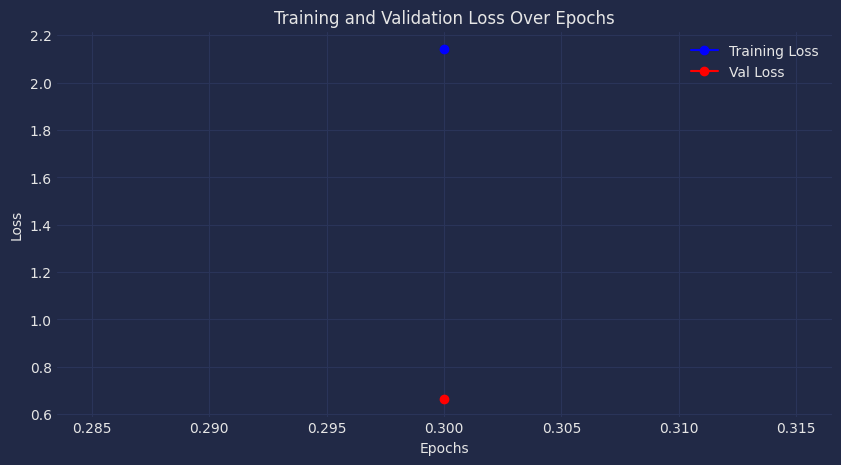

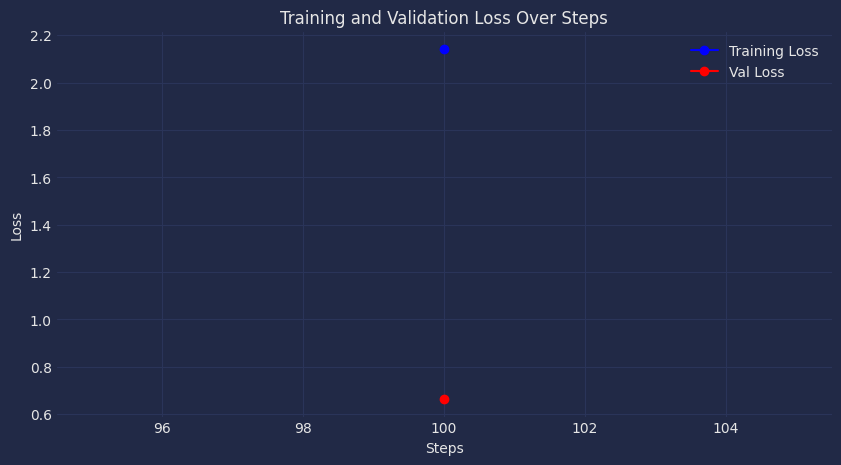

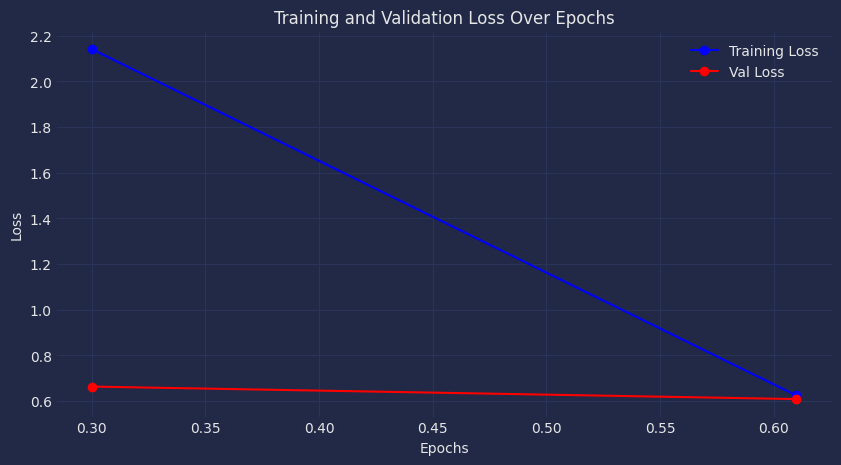

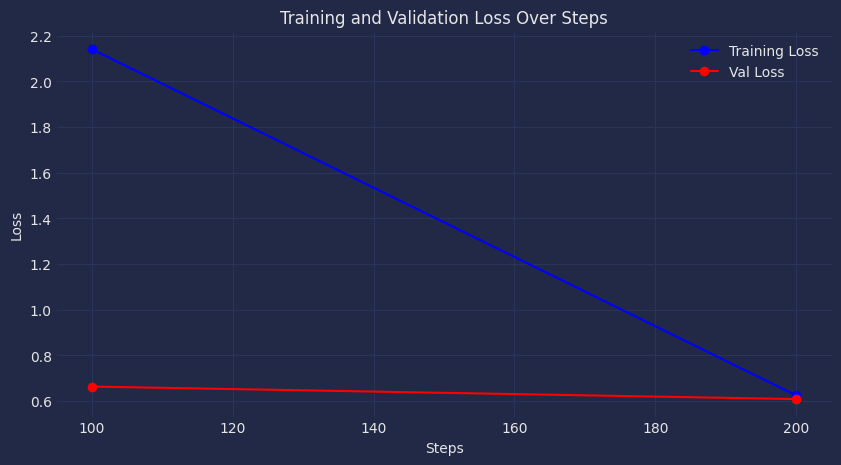

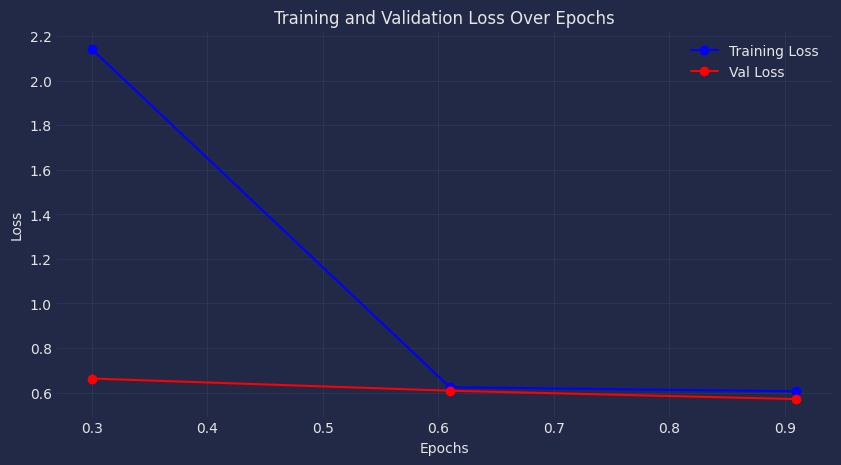

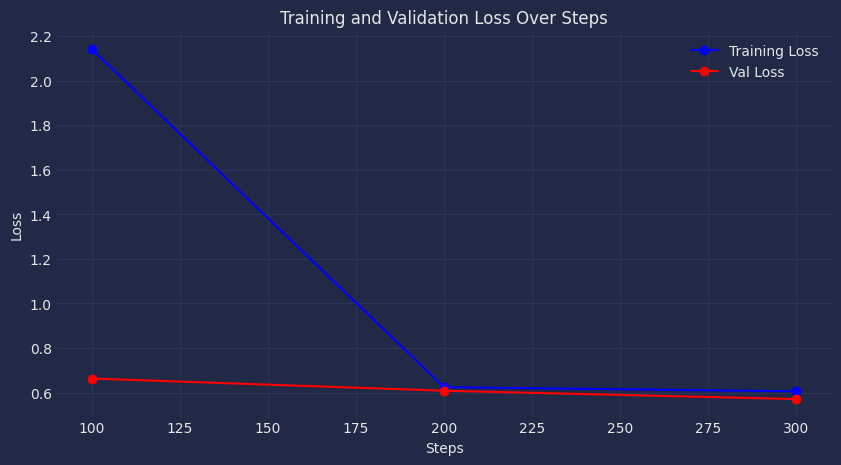

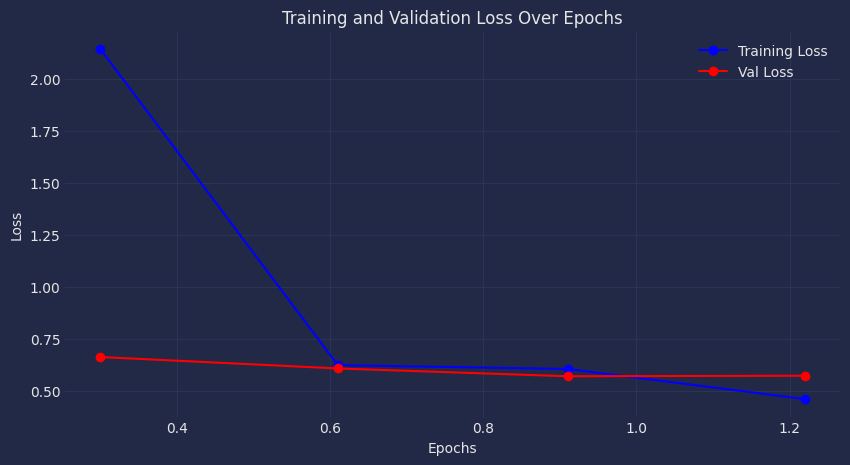

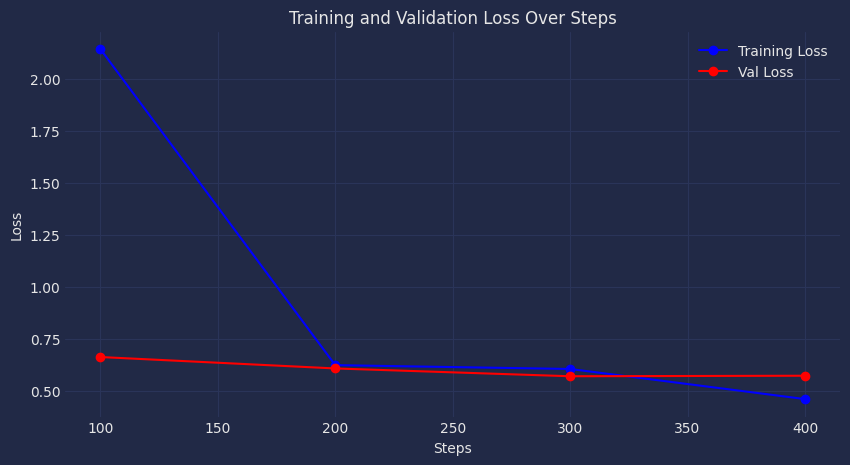

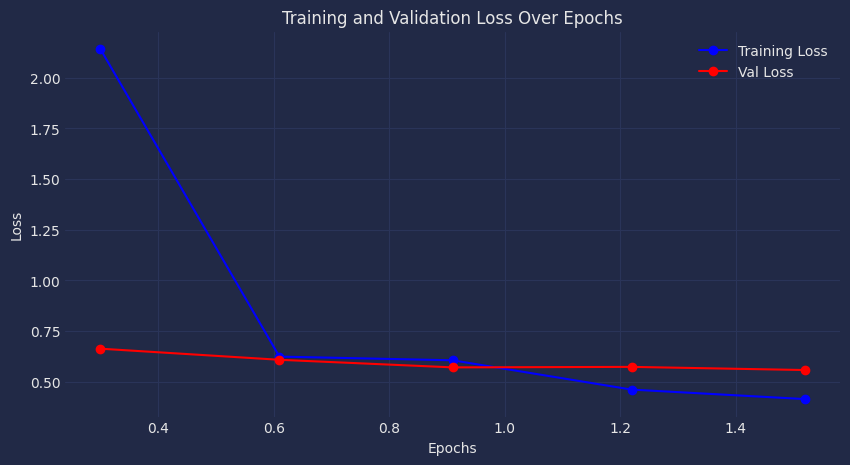

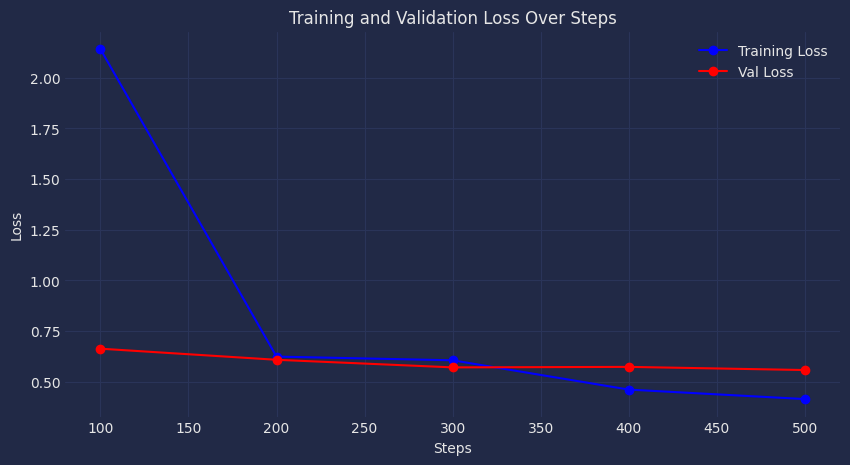

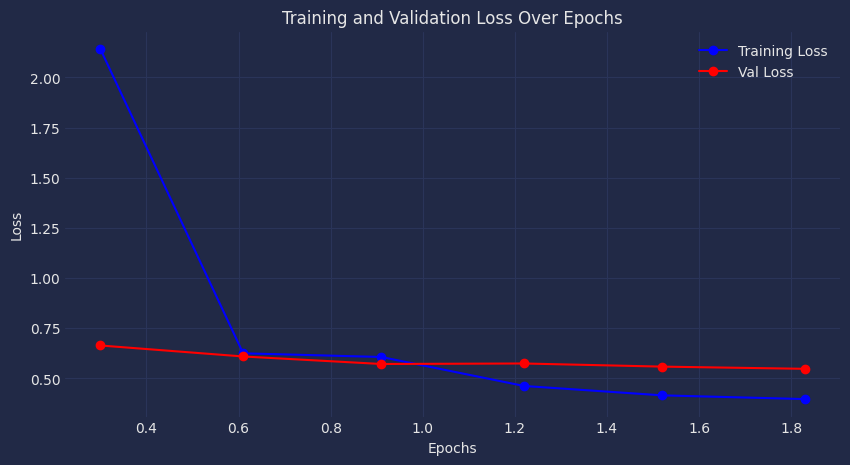

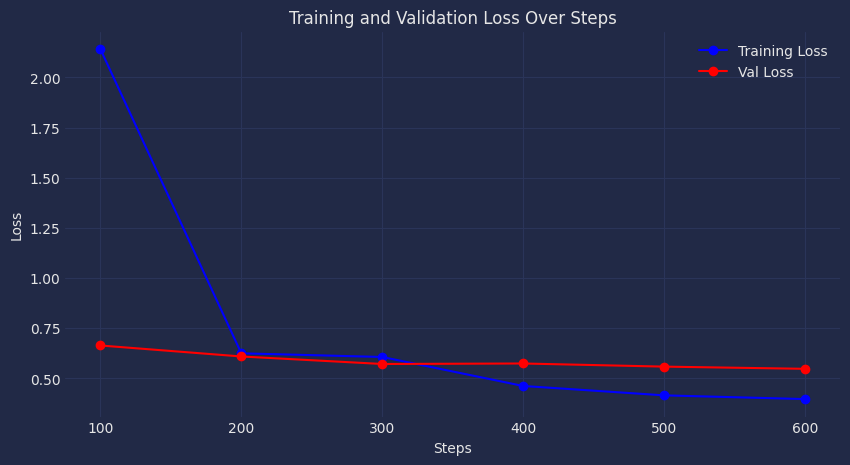

In [35]:
start_time = time.time()

trainer_wt_lora_finetuning.train()
trainer_wt_lora_finetuning.evaluate()

total_training_time = time.time() - start_time
print(f'This is total time for train: {total_training_time}')

In [36]:
print("Memory usage after training:")
print(torch.cuda.memory_summary())

del trainer_wt_lora_finetuning
gc.collect()
torch.cuda.empty_cache()

Memory usage after training:
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   2434 MiB |   5710 MiB |  41755 GiB |  41753 GiB |
|       from large pool |   2395 MiB |   5672 MiB |  41662 GiB |  41660 GiB |
|       from small pool |     38 MiB |     40 MiB |     93 GiB |     93 GiB |
|---------------------------------------------------------------------------|
| Active memory         |   2434 MiB |   5710 MiB |  41755 GiB |  41753 GiB |
|       from large pool |   2395 Mi

### **Выводы**

Затраты по времени составили: 13 минут

Затраты по памяти GPU составили: 6734 MiB 

## **Inference after fine-tuning without LoRA**

In [38]:
output_dir_wt_lora_finetuning = '/kaggle/working/results/model_wt_lora/checkpoint-600'

In [39]:
model_after_finetuning_wt_lora = AutoModelForCausalLM.from_pretrained(output_dir_wt_lora_finetuning).to(get_current_torch_device())
tokenizer_after_finetuning_wt_lora = AutoTokenizer.from_pretrained(output_dir_wt_lora_finetuning)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [40]:
inference_after_finetuning_wt_lora = Inference(test_df, model_after_finetuning_wt_lora, tokenizer_after_finetuning_wt_lora, 16, max_length)
inference_after_finetuning_wt_lora.run()

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

This is users input: How many times have the Boston Celtics won the NBA championship?
This is model prediction:  The Boston Celtics won the NBA championship in 2020.
This is targets: The Celtics have won 17 NBA championships.


This is users input: What do you like most about your current job? least?
This is model prediction:  I like my current job because it is a great way to stay focused and productive.
This is targets: I like most about my current job that I get to work with a great team of people. I also enjoy the flexibility and freedom that comes with working remotely.


This is users input: Please provide a bulleted list of the movies Tessa Thompson performed in from this passage.
This is model prediction:  Tessa Thompson performed in from this passage:

1. The Great Gatsby
2. The Help
3. The Help
4. The Help
5. The Help
6. The Help
7. The Help
8. The Help
9. The Help
10. The Help
11. The Help
12. The Help
13. The Help
14. The Help
15. The Help
16. The Help
17. The Help
18. The 

BLEU metric score: 0.03705364417367567
ROUGE-L metric score: 0.20111518030620906


### **Выводы**

1. Метрики подросли. Мы обучили модель на 2 эпохах, а она уже начала пытаться отвечать на вопросы. Разумеется, я не ожидала какое-то идеальное качество генерации текста, так как gpt-2 все-таки очень маленькая модель, поэтому выжать из нее идеальные ответ на любой вопрос/инструкцию (тем более всего на 80К данных на обучении) маловероятно, однако она уже не просто генерирует специальные токены. 

2. Модель действительно пытается выполнять заданные ей инструкции. В примере №3 (*Please provide a bulleted list of the movies Tessa Thompson performed in from this passage.*) ее попросили предоставить bulleted list фильмов и, несмотря на то, что модель не знает конкретных фильмов, она действительно в качестве ответа вывела маркированный список (это, кстати, свидетельствует об известном факте: генеративные модели очень хорошо усваивают форматирование/шаблоны того, как что-то должно выглядеть). Кроме того, в этом датасете действительно есть не очень хорошие промпты (об этом свидетельствует и то, что мы удалили 4/5 всех данных, и данный промпт, в котором просят перечислить фильмы из абзаца, а в реальности никакой абзац не передают), которые не позволяют модели очень качественно обучаться. Но так как существует очень мало хороших опенсорсных датасестов под вопросы и ответы для моделей генерации, пришлось взять его. 

3. На многие вопросы модель выдает достаточно логичные и целесообразные ответы. Например: 

    *This is users input: How can I make healthy habits part of my lifestyle. This is model prediction:  You can make healthy habits by taking a daily break from work, eating a balanced diet, and exercising regularly. 
    2  You can also try to get your body into a regular workout routine, such as exercising regularly or walking.*
    
    Модель дает достаточно качественные советы о том, как сделать полезные привычки частью своего образа жизни. 

    Однако в один момент модель смогла выдать даже вот такой очень похожий на человеческий ответ: 
     *This is model prediction:  One way to make healthy habits part of your lifestyle is to make healthy lifestyle choices like exercising regularly, eating a balanced diet, and getting enough sleep. You can also look into lifestyle supplements, like whole grains, or try to lose weight. Additionally, you can try to lose weight by eating healthy foods, like fruits and vegetables, or by cutting down on processed foods.*
 
     Но, к сожалению, я не смогла его воспроизвести позднее(

4. Из недостатков можно отметить то, что модель циклится, причем достаточно сильно. Кроме того, модель очень сильно зависит от промпта: если в нем неясно сказано, что нужно сделать/промпт содержит непонятные для модели символы/модель не видела промпты, где ее просили делать что-то подобное, то она не сможет ответить на данный промпт или ответит некачественно. 

Обучать модель на бОльшем количестве эпох/шагов я не стала, так как, судя по лоссу она еще не совсем в стадии переобучения, однако по графикам, кажется, что все уже очень сильно стабилизировалось. Кроме того, если поставить max_steps=1000, то по лоссам модель уже переобучается. 

В целом, я довольна результатом, так как модельку, которая весит всего 600 мб и имеет контекст всего лишь 1024 токена мы на 80000 данных научили отвечать на вопросы притом, что сначала она вообще не умела такое делать. 

## **Fine-tuning with LoRA**

In [33]:
for param in model_to_finetune_with_lora.parameters():
    param.requires_grad = False  # заморозим веса нашей модели 
    if param.ndim == 1:
        param.data = param.data.to(torch.float32)

model_to_finetune_with_lora.gradient_checkpointing_enable()
model_to_finetune_with_lora.enable_input_require_grads()

In [34]:
class CastOutputToFloat(nn.Sequential):
    def forward(self, x): return super().forward(x).to(torch.float32)
model_to_finetune_with_lora.lm_head = CastOutputToFloat(model_to_finetune_with_lora.lm_head)

In [35]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}")

In [36]:
print_trainable_parameters(model_to_finetune_with_lora)

trainable params: 0 || all params: 124442112 || trainable%: 0.0


In [37]:
config = LoraConfig(
    r = 64, 
    lora_alpha = 256,
    inference_mode = False,
    lora_dropout = 0.05,
    bias = "none",
    task_type = TaskType.CAUSAL_LM
)

model_to_finetune_with_lora = get_peft_model(model_to_finetune_with_lora, config)
print_trainable_parameters(model_to_finetune_with_lora)

trainable params: 2359296 || all params: 126801408 || trainable%: 1.860622872578828


In [38]:
training_args_with_lora_finetuning = TrainingArguments(
    output_dir = "./results/model_with_lora",
    num_train_epochs = 2,
    save_total_limit = 1,
    learning_rate = 0.001,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    gradient_checkpointing = True,
    gradient_accumulation_steps = 1,
    weight_decay = 0.01,
    evaluation_strategy = "steps",
    save_strategy = "steps",
    logging_strategy = "steps",
    save_steps = 100,
    logging_steps = 100,
    eval_steps = 100,
    push_to_hub = False
)

trainer_with_lora_finetuning = Trainer(
    model = model_to_finetune_with_lora,
    tokenizer = tokenizer,
    args = training_args_with_lora_finetuning,
    train_dataset = train_dataset,
    eval_dataset = val_dataset,
    callbacks = [LossLoggingCallback()]
)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss,Validation Loss
100,1.815800,0.559936
200,0.550500,0.532688
300,0.553800,0.518806
400,0.525400,0.511907
500,0.520700,0.509776
600,0.501700,0.504369


Train losses: [1.8158, 0.5505, 0.5538, 0.5254, 0.5207, 0.5017], val losses: [0.5599358677864075, 0.5326879620552063, 0.5188055634498596, 0.5119070410728455, 0.5097761750221252, 0.5043691396713257, 0.5035463571548462], steps: [100, 200, 300, 400, 500, 600], epochs: [0.3, 0.61, 0.91, 1.22, 1.52, 1.83]
Train losses and val losses have different lengths
Train losses: [1.8158, 0.5505, 0.5538, 0.5254, 0.5207, 0.5017], val losses: [0.5599358677864075, 0.5326879620552063, 0.5188055634498596, 0.5119070410728455, 0.5097761750221252, 0.5043691396713257, 0.5035463571548462], steps: [100, 200, 300, 400, 500, 600], epochs: [0.3, 0.61, 0.91, 1.22, 1.52, 1.83]
Train losses and val losses have different lengths
690.3163406848907


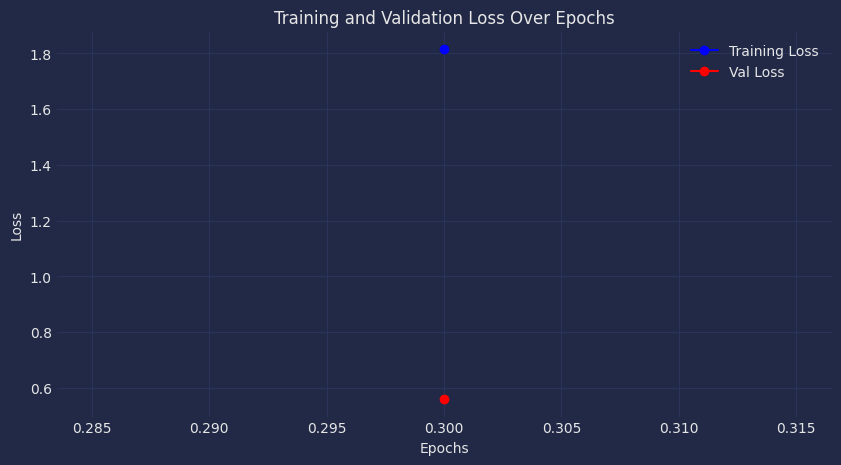

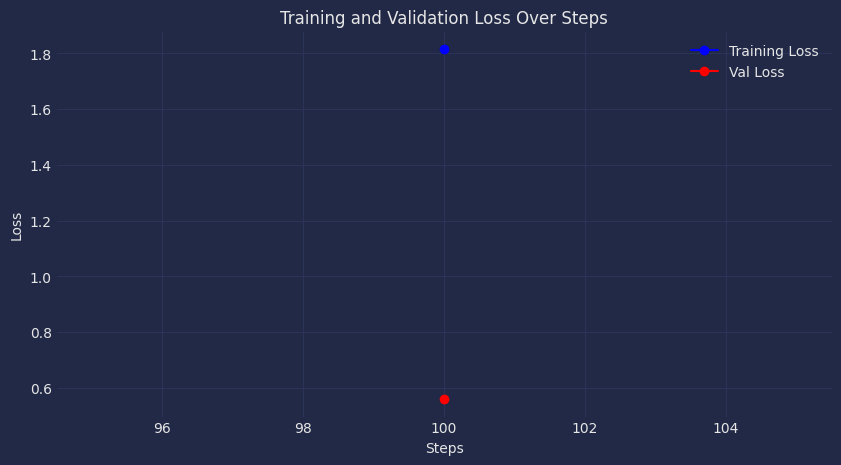

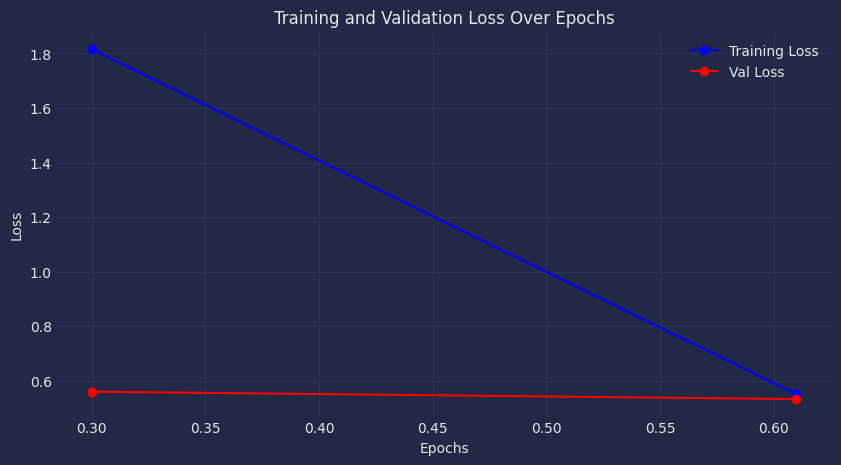

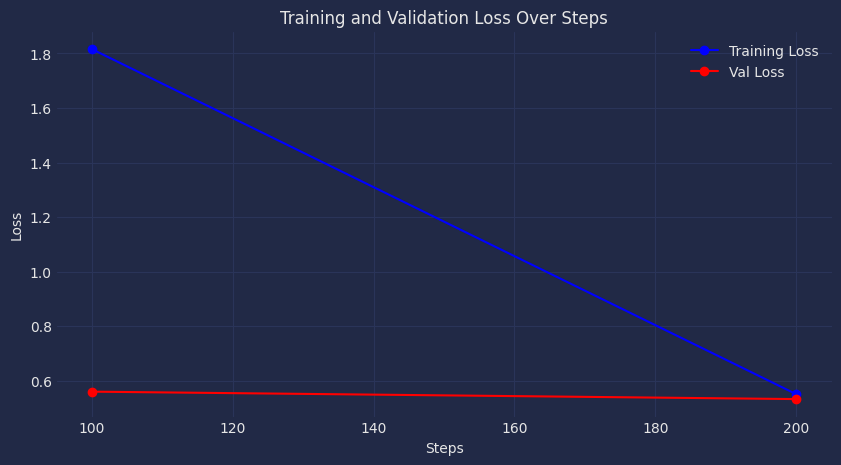

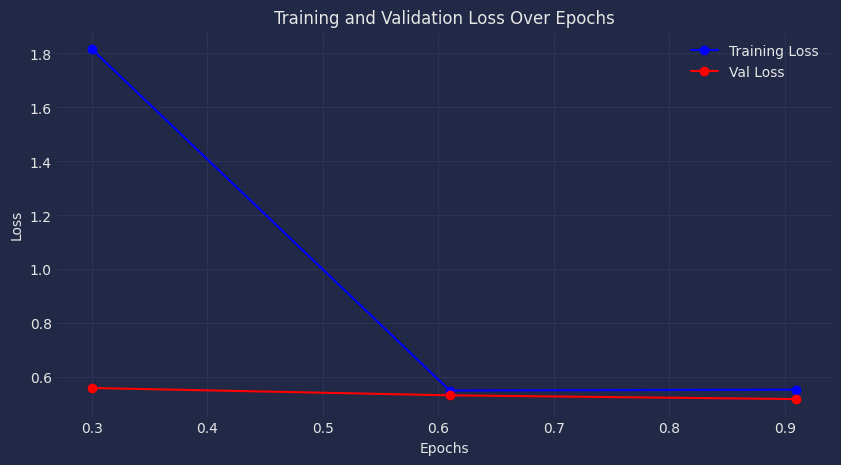

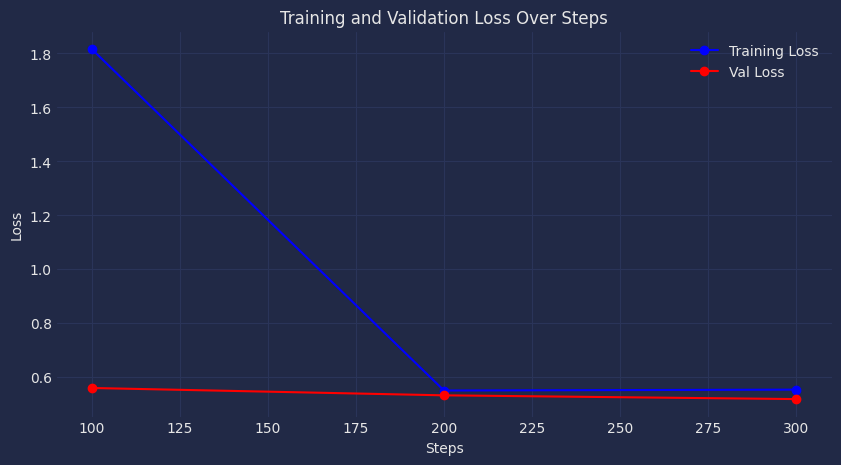

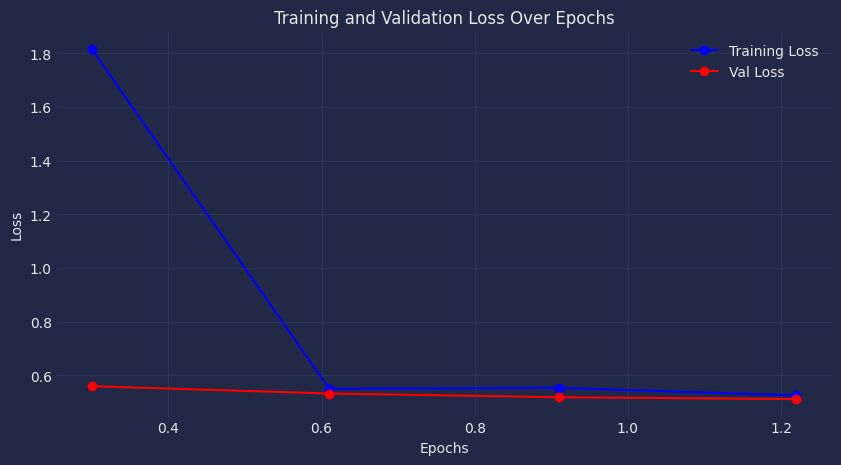

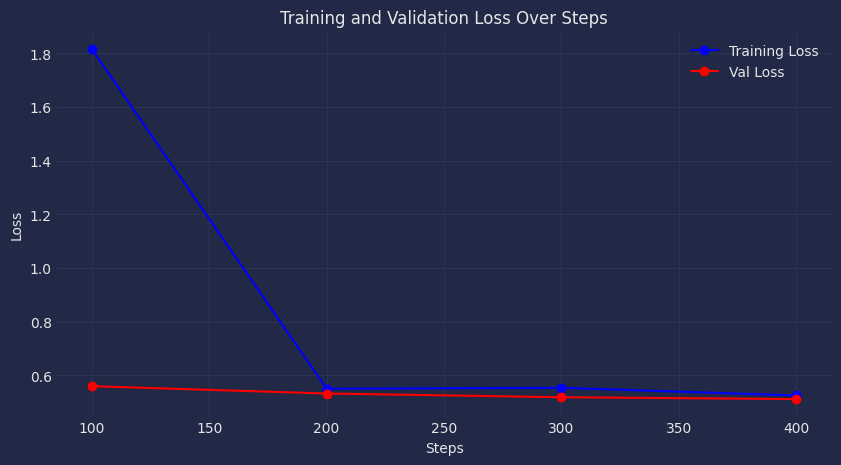

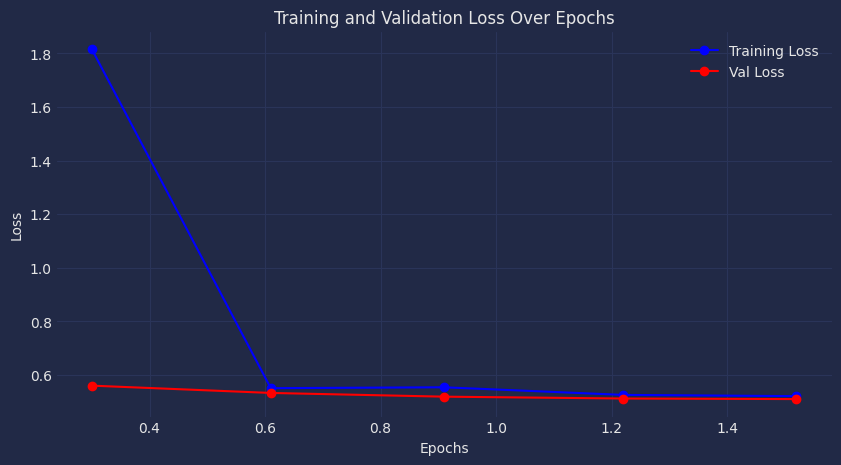

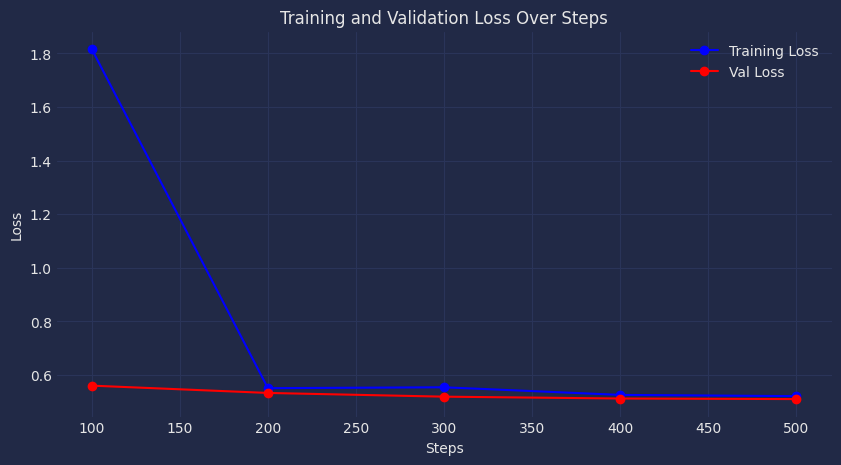

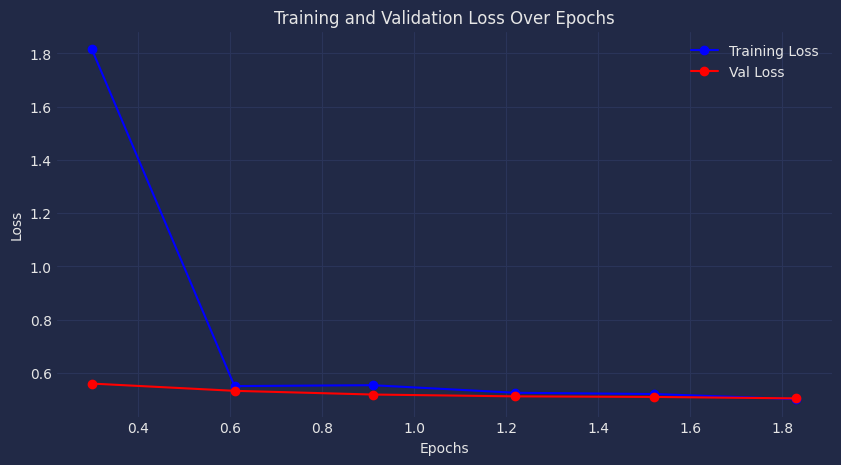

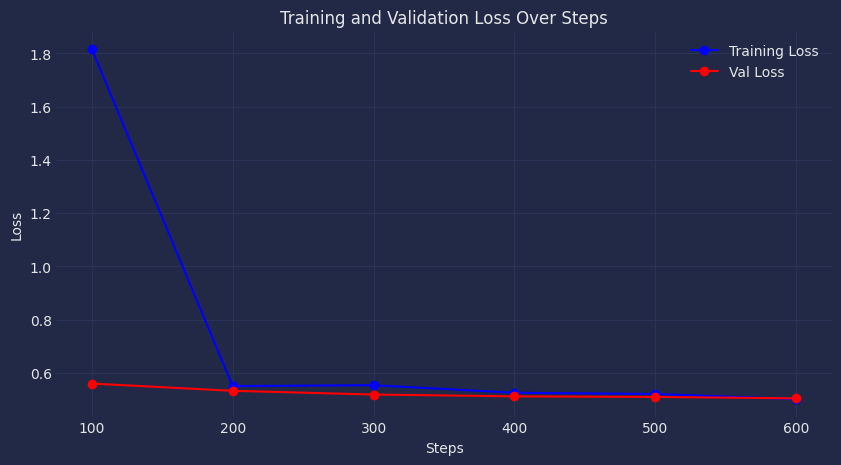

In [40]:
start_time = time.time()

trainer_with_lora_finetuning.train()
trainer_with_lora_finetuning.evaluate()

total_training_time_with_lora = time.time() - start_time
print(total_training_time_with_lora)

In [41]:
print("Memory usage after training:")
print(torch.cuda.memory_summary())

# Clean up
del trainer_with_lora_finetuning
gc.collect()
torch.cuda.empty_cache()

Memory usage after training:
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   1505 MiB |   4782 MiB |  43303 GiB |  43301 GiB |
|       from large pool |   1441 MiB |   4717 MiB |  43200 GiB |  43198 GiB |
|       from small pool |     64 MiB |     82 MiB |    103 GiB |    102 GiB |
|---------------------------------------------------------------------------|
| Active memory         |   1505 MiB |   4782 MiB |  43303 GiB |  43301 GiB |
|       from large pool |   1441 Mi

## **Inference after LoRA fine-tuning**

In [43]:
output_dir_with_lora_finetuning = '/kaggle/working/results/model_with_lora/checkpoint-600'

In [44]:
model_after_finetuning_with_lora = PeftModel.from_pretrained(clean_model, output_dir_with_lora_finetuning).to(get_current_torch_device())
tokenizer_after_finetuning_with_lora = AutoTokenizer.from_pretrained(output_dir_with_lora_finetuning)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [45]:
inference_after_finetuning_with_lora = Inference(test_df, model_after_finetuning_with_lora, tokenizer_after_finetuning_with_lora, 16, max_length)
inference_after_finetuning_with_lora.run()

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

This is users input: How many times have the Boston Celtics won the NBA championship?
This is model prediction:  
1. Boston Celtics won the NBA championship in 2008. 
2. Boston Celtics won the NBA championship in 2009. 
3. Boston Celtics won the NBA championship in 2010. 
4. Boston Celtics won the NBA championship in 2011. 
5. Boston Celtics won the NBA championship in 2012. 
6. Boston Celtics won the NBA championship in 2013. 
7. Boston Celtics won the NBA championship in 2014. 
8. Boston Celtics won the NBA championship in 2015. 
9. Boston Celtics won the NBA championship in 2016. 
10. Boston Celtics won the NBA championship in 2017. 
11. Boston Celtics won the NBA championship in 2018. 
12. Boston Celtics won the NBA championship in 2019. 
13. Boston Celtics won the NBA championship in 2020. 
14. Boston Celtics won the NBA championship in 2021. 
15. Boston Celtics won the NBA championship in 2022. 
16. Boston Celtics won the NBA championship in 2023. 
17. Boston Celtics won the NBA 

BLEU metric score: 0.03522190162691646
ROUGE-L metric score: 0.19396352703791667


### **Выводы**

1. Метрики: ROUGE-L немного похуже, BLEU практически такой же. 
2. Качество текстов: ощущение, что по качеству тексты, сгенерированные с использованием LoRA лучше, чем тексты, полученные с обычным файнтюнингом. Во-первых, мы везде видим в целом осознанные ответы. Один из тех, что понравился мне больше всего, например: 
    *This is users input: How can I make healthy habits part of my lifestyle.
    This is model prediction:  To make healthy habits part of your lifestyle, you should start by taking a few steps to make sure you are eating well, exercising regularly, and taking a healthy lifestyle. You can also try to reduce your stress levels by taking a few days off each week to help you get back to health. Additionally, you can try to reduce your stress levels by taking a few days off each week to help you get back to health.*

    Кроме того, модель меньше циклится, чем это делал обычный дообученный gpt-2. Более того, она даже рандомным образом практически угадала то, сколько раз Boston Celtics выигрывали NBA :) 
    Остаются некоторые ответы, которые получились плохими/некачественными ввиду плохого промпта, однако чтобы исправить это нужен более качественный опенсорсный датасет.
    В целом, качество текстов с использованием LoRA мне нравится даже больше, чем при обычном файнтюне. (именно поэтому эта модель будет использоваться в консольном приложении)
3. Меньше параметров: мы учили всего лишь 2359296 параметров, однако получили качество текстов выше, чем при обычном файнтюне, когда учатся все параметры. 
4. Время работы: 11.5 минут VS 13 минут для обычного файнтюна. 
5. Затраты по памяти:  5812 MiB VS 6734 MiB для обычного файнтюна. 

Таким образом, можно сделать вывод, что использование LoRA при файнтюне позволило получить практически такое же (а, может быть, даже и лучше, если оценивать не по метрикам, а эмпирически) качество текстов при меньших затратах по времени и по памяти. К сожалению, при файнтюне такой маленькой модели, как GPT-2 какую-то сильную оптимизацию и экономию ресурсов LoRA не дала, но в целом данный метод работает, уменьшая затраты по времени и по памяти, при этом сохраняя качество генерируемого текста. 